## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
from keras.models import load_model

## Defining functions for visualization and evaluation

In [2]:
def visualize_on_sphere(data_points, title):
    #Defining the visualization
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect(aspect = (1,1,1))
    ax.view_init(10, 60)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    #Defining the sphere coordinates
    u = np.linspace(0, 2*np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    
    #Defining axis connecting polarization states (H-V, D-A, R-L)
    HV_1 = np.linspace(-1, 1, 2)
    HV_2 = np.zeros(len(HV_1))
    HV_3 = np.zeros(len(HV_1))
    
    DA_2 = np.linspace(-1, 1, 2)
    DA_1 = np.zeros(len(DA_2))
    DA_3 = np.zeros(len(DA_2))
    
    RL_3 = np.linspace(-1, 1, 2)
    RL_1 = np.zeros(len(RL_3))
    RL_2 = np.zeros(len(RL_3))
    
    #Plotting
    ax.plot_surface(x, y, z, color='white', alpha=0.45) #surface of sphere
    ax.plot(HV_1, HV_2, HV_3, color="black") #axis H-V
    ax.plot(DA_1, DA_2, DA_3, color="black") #axis D-A
    ax.plot(RL_1, RL_2, RL_3, color="black") #axis R-L
    
    ax.scatter(data_points[:,0], data_points[:,1], data_points[:,2], s=2.5, color='blue', alpha=0.85) #Logo points
    
    plt.title(title, fontdict = {'fontsize' : 20})

#Transforming the cartesian Stokes parameters to density matrices
def cart_to_density(cart):
    rho = np.zeros([cart.shape[0], 2, 2], dtype=np.complex_)
    rho[:, 0, 0] = 1/2 * (1 + cart[:, 0])
    rho[:, 0, 1] = 1/2 * (cart[:, 1] - 1j*cart[:, 2])
    rho[:, 1, 0] = 1/2 * (cart[:, 1] + 1j*cart[:, 2])
    rho[:, 1, 1] = 1/2 * (1 - cart[:, 0])
    return rho

## Visualization of ideal logo

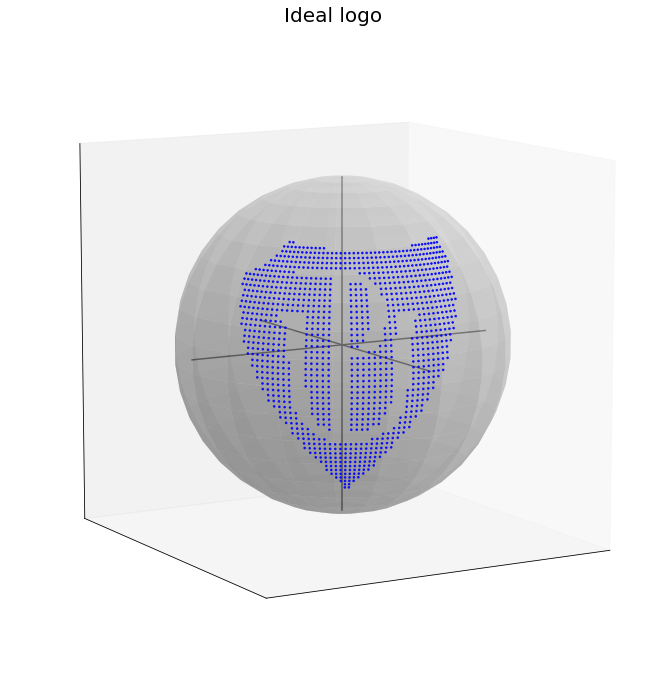

In [3]:
#Load the dataset of cartesian coordinates representing the Stokes parameters
ideal_logo_points = np.load("Dataset_files/logo_points_cartesian.npy")

#Visualize the coordinates on the Bloch sphere
visualize_on_sphere(ideal_logo_points, "Ideal logo")

#Transform the Stokes parameters to density matrices
true_rho = cart_to_density(ideal_logo_points)

## Weak signal - heralded photon pairs

In [4]:
#Computing fidelity
def fidelity_array(input_1, input_2):
    fid_int = []
    for i in range(input_1.shape[0]):
        dm_sqrt = scipy.linalg.sqrtm(input_1[i])
        dm_pred = input_2[i]
        in_sqrt = np.linalg.multi_dot([dm_sqrt, dm_pred, dm_sqrt])
        trace = np.trace(linalg.sqrtm(in_sqrt))
        fidelity = np.real(trace**2)
        fid_int.append(fidelity)
    return np.array(fid_int)

In [5]:
#Loading the dataset of measured polarization states using heralded photon-pairs
measured_weak_stokes = np.load("Dataset_files/weak_signal_heralded_stokes.npy")
measured_weak_rho = cart_to_density(measured_weak_stokes)

In [6]:
#Evaluation of results
WSH_fidelities = fidelity_array(true_rho, measured_weak_rho)
print("Average fidelity between ideal logo and localy prepared logo:", np.mean(WSH_fidelities))
print("The 5th percentile of fidelities:", np.quantile(WSH_fidelities, 0.05))
print("The 95th percentile of fidelities:", np.quantile(WSH_fidelities, 0.95))
print("")

print("The format of fidelities in the article:")
print("(", np.mean(WSH_fidelities), 
      "-", np.mean(WSH_fidelities)-np.quantile(WSH_fidelities, 0.05), 
      "+", np.quantile(WSH_fidelities, 0.95)-np.mean(WSH_fidelities), ")")

Average fidelity between ideal logo and localy prepared logo: 0.998065909563596
The 5th percentile of fidelities: 0.9923653094774797
The 95th percentile of fidelities: 0.9999848506963009

The format of fidelities in the article:
( 0.998065909563596 - 0.005700600086116281 + 0.0019189411327049655 )


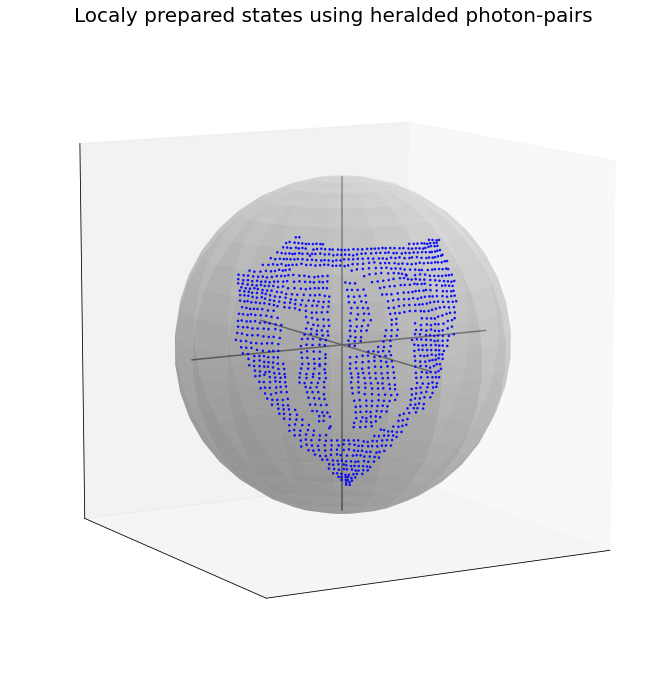

In [7]:
visualize_on_sphere(measured_weak_stokes, "Localy prepared states using heralded photon-pairs")

## Numerical simulation of remote state preparation

### Compound model supplementing measurement operators $\Pi_1$

In [8]:
#Extracting density matrix information to input vector for compound model
def flatten_rho(rho):
    flat_rho = np.zeros([rho.shape[0], 4])
    flat_rho[:, 0] = np.real(rho[:, 0, 0])
    flat_rho[:, 1] = np.real(rho[:, 1, 0])
    flat_rho[:, 2] = np.imag(rho[:, 1, 0])
    flat_rho[:, 3] = np.real(rho[:, 1, 1])
    return flat_rho

#Inverse Cholesky transformation using 4 outputs predicted by the neural network
def prediction_to_density(flat):
    tau = np.zeros([flat.shape[0], 2, 2], dtype=np.complex_)
    tau[:, 0, 0] = flat[:, 0]
    tau[:, 0, 1] = 0
    tau[:, 1, 0] = flat[:, 1] + 1j*flat[:, 2]
    tau[:, 1, 1] = flat[:, 3]
    rho = np.zeros([tau.shape[0], 2, 2], dtype=np.complex_)
    for i in range(rho.shape[0]):
        rho[i] = np.dot(tau[i], np.conjugate(np.transpose(tau[i])))
        rho[i] = rho[i] / np.trace(rho[i])
    return rho

#Transforming density matrix to cartesian Stokes paramters
def density_to_stokes(rho):
    S1 = 2*rho[:,0,0] - 1
    S2 = 2*np.real(rho[:,0,1])
    S3 = -2*np.imag(rho[:,0,1])
    return np.real(np.transpose(np.array([S1,S2,S3])))

In [9]:
#Compound model predicting states for the logo points
compound_model = load_model("Compound_model.h5")
compound_pred_rho = prediction_to_density(compound_model.predict(flatten_rho(true_rho)))
compound_pred_stokes = density_to_stokes(compound_pred_rho)

### Remote state preparation

rho_AB     =  4x4 density matrix of entangled state <br>
Pi_A       =  2x2 projector / density matrix of a state predicted by compound model <br>
rho_B      =  2x2 density matrix of a state prepared by a numerically simulated remote preparation <br>

In [10]:
#Partial trace over subsystem A for 4x4 matrix
def partial_trace_over_A_4d(matrix):
    output = matrix[:2,:2] + matrix[2:,2:]
    return output

#Unitary operation i*sigma_2 correcting the effect of singlet entangled state
def unitary_operation_for_singlet(density_matrix):
    unitary_oper = np.array([[0,1], [-1,0]])
    output = np.dot(np.dot(unitary_oper, density_matrix), np.transpose(np.conjugate(unitary_oper)))
    return output

#Implementing numericall simulation of remote state praparation
def remote_preparation(rho_AB, Pi_A):
    Pi_AB = np.kron(Pi_A, np.identity(2))
    inside_trace = np.dot(rho_AB, Pi_AB)
    pre_rho_B = partial_trace_over_A_4d(inside_trace)
    rho_B = unitary_operation_for_singlet(pre_rho_B)
    return np.conjugate(rho_B)

In [11]:
#Loading the entangled state
rho_AB = np.load("Dataset_files/entangled_state_density_matrix_MN.npy").astype("complex128")

In [12]:
#Remote preparation for each point of the logo
remote_pred_rho = []
for i in range(compound_pred_rho.shape[0]):
    Pi_A = compound_pred_rho[i]
    rho_B = remote_preparation(rho_AB, Pi_A)
    remote_pred_rho.append(rho_B / np.trace(rho_B))

remote_pred_rho = np.array(remote_pred_rho)
remote_pred_stokes = density_to_stokes(remote_pred_rho)

### Remote state preparation results evaluation

In [13]:
#Evaluation of results
RSP_fidelities = fidelity_array(true_rho, remote_pred_rho)
print("Average fidelity between ideal logo and localy prepared logo:", np.mean(RSP_fidelities))
print("The 5th percentile of fidelities:", np.quantile(RSP_fidelities, 0.05))
print("The 95th percentile of fidelities:", np.quantile(RSP_fidelities, 0.95))
print("")

print("The format of fidelities in the article:")
print("(", np.mean(RSP_fidelities), 
      "-", np.mean(RSP_fidelities)-np.quantile(RSP_fidelities, 0.05), 
      "+", np.quantile(RSP_fidelities, 0.95)-np.mean(RSP_fidelities), ")")

Average fidelity between ideal logo and localy prepared logo: 0.9879086074343661
The 5th percentile of fidelities: 0.9865383754404281
The 95th percentile of fidelities: 0.9898778710503541

The format of fidelities in the article:
( 0.9879086074343661 - 0.0013702319939380425 + 0.001969263615987926 )


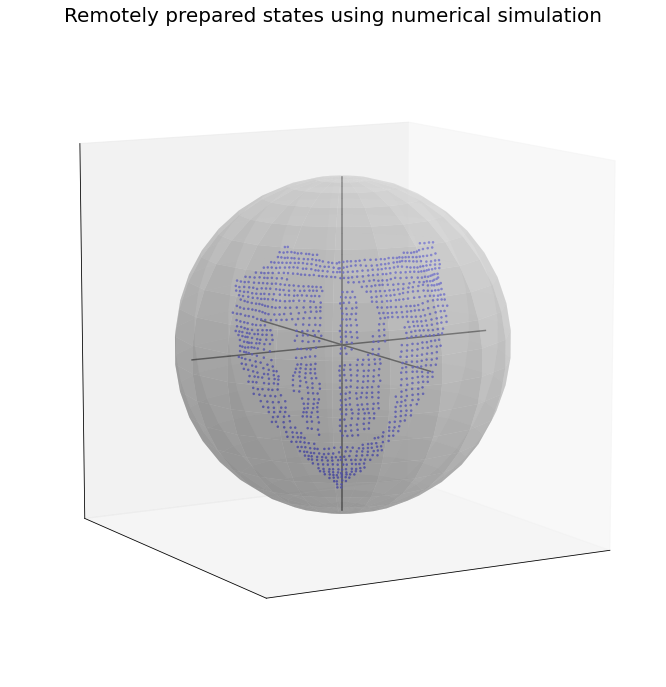

In [14]:
visualize_on_sphere(remote_pred_stokes, "Remotely prepared states using numerical simulation")